# Signal from Hidden Markov Models (regime detection)

### Import

In [1]:
from __future__ import print_function

import datetime
import warnings

from pathlib import Path 

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns

### Get data

In [2]:
filepath = Path('../../data/csv/Binance_BTCUSDT_1h.csv')

In [3]:
def obtain_prices_df(csv_filepath, crop, nb_days):
    """
    Obtain the prices DataFrame from the CSV file, filter by the end date and calculate the REALIZED VOLATILITY.
    """
    df = pd.read_csv(csv_filepath)
    
    if crop:
        df = df[-nb_days*24:]
    
    df = df[::-1].reset_index().drop(columns=['index', 'unix', 'tradecount', 'symbol', 'open', 
                                              'high', 'low', 'Volume BTC', 'Volume USDT'])

    df["Realized_Vol"] = (((df["close"].pct_change())**2).rolling(24).sum())
    df = df.dropna().reset_index().drop(columns=['index']).set_index('date')

    # Scaling
    df["Realized_Vol"] = df["Realized_Vol"] / df["Realized_Vol"][0]

    return df

In [4]:
BTC = obtain_prices_df(filepath, False, 10) # last two parameters are not important (just when I did some tests)

In [5]:
BTC

close  Realized_Vol
date                                       
2017-08-18 04-AM      4287.92      1.000000
2017-08-18 05-AM      4313.56      1.014009
2017-08-18 06-AM      4279.46      1.038321
2017-08-18 07-AM      4300.25      1.033487
2017-08-18 08-AM      4282.73      1.037900
...                       ...           ...
2022-04-16 20:00:00  40280.00      0.068871
2022-04-16 21:00:00  40485.28      0.079516
2022-04-16 22:00:00  40405.86      0.080685
2022-04-16 23:00:00  40378.71      0.079054
2022-04-17 00:00:00  40376.49      0.079038

[40848 rows x 2 columns]

In [6]:
df_train = BTC[BTC.index < '2020']
df_output = BTC[BTC.index >= '2020']

### Train model

Create the Gaussian Hidden markov Model and fit it to the BTC realized_volatility data

In [7]:
Realized_Vol = np.column_stack([df_train["Realized_Vol"]])

In [8]:
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(Realized_Vol)
print("Model Score:", hmm_model.score(Realized_Vol))

Model Score: -15566.180483774073


Create a visualizer to plot the detected regimes on the train set

In [9]:
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by the in-sample hidden states as a mechanism to understand the market regimes.
    """
    df = df.reset_index().drop(columns = ['date'])
    
    # Predict the hidden states array with the already trained HMM
    hidden_states = hmm_model.predict(Realized_Vol)
    
    # Plot the sub-regimes
    fig, axs = plt.subplots(hmm_model.n_components, sharex=True, sharey=True)
    colours = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Realized_Vol"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.grid(True)
        
    plt.show()

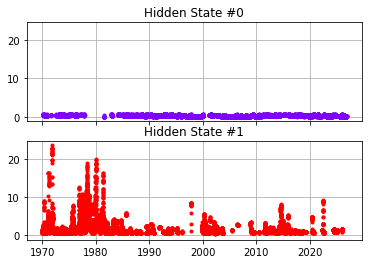

In [10]:
plot_in_sample_hidden_states(hmm_model, df_train)

### Predict signal

In [11]:
Realized_Vol_test = np.column_stack([df_output["Realized_Vol"]])

predicted_regimes = hmm_model.predict(Realized_Vol_test)

In [12]:
pd.Series(predicted_regimes).value_counts()

0    14408
1     5664
dtype: int64

In [13]:
df_signal = pd.DataFrame(predicted_regimes, index=df_output.index, columns=['HMM_detected_regime'])
df_signal.head(3)

HMM_detected_regime
date                                 
2020-01-01 12-AM                    1
2020-01-01 01-AM                    0
2020-01-01 02-AM                    0

### Save signal

In [14]:
filepath = Path('../csv/signals_HMM_regime_detection.csv')

In [15]:
df_signal.to_csv(filepath)

## What to do next:
- see what we can do to optimize the HMM training